## Introduction
This project data comes from a Kaggle competition held in 2022 and can be found here https://www.kaggle.com/competitions/autismdiagnosis/overview
The data comes from a survey that had questions asked relating to certain attributes that people with Autism commonly display, then they were asked some demographic information about themselves. The purpose of this data is to create a model that could be used in theory with other participant data to get an idea to whether they should seek an ASD diagnosis or not. 

## Data

A1_Score - A10_Score: Questions asked in a survey, 1 being 'yes' and 0 being 'no'

Age: Age in years scaled to between 0 and 1

Male: 0 for the person being a female and 1 if they are male

Jaundice: 1 for if the person was diagnosed with Jaundice at birth and 0 if they weren't

ASD_relative: 1 if they know of someone in their close relatives that was diagnosed with ASD during their lifetime

result: Score for AQ1-10 screening test

Class/ASD: Classified result as 0 or 1. 0 represents No and 1 represents Yes. This is the target column.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score


In [5]:
autism = pd.read_csv('train_scaled.csv')
autism.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,male,jaundice,ASD_relative,result,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,0.408986,0,0,0,0.567985,0
1,0,0,0,0,0,0,0,0,0,0,0.519585,1,0,0,0.381992,0
2,1,1,1,1,1,1,1,1,1,1,0.054147,1,0,1,0.954525,1
3,0,0,0,0,0,0,0,0,0,0,0.240783,0,0,0,0.382901,0
4,0,0,0,0,0,0,0,0,0,0,0.466590,1,0,0,0.061846,0


In [6]:
X = autism.drop('Class/ASD', axis=1)
y = autism['Class/ASD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

# A. Random Forest

In [7]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", rf_accuracy)


Accuracy: 0.8208333333333333


In [8]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[171,  17],
       [ 26,  26]], dtype=int64)

In [17]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'criterion': ['gini', 'entropy']}
    
rf_classifier = RandomForestClassifier()
    
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
    
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best Score: 0.8892857142857142
Accuracy: 0.8208333333333333


In [37]:
rf = RandomForestClassifier(criterion='gini', max_depth=5, max_features='sqrt', min_samples_leaf=2, min_samples_split=10, n_estimators=100)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8208333333333333

        Features  Importance scores
0       A1_Score           0.010638
1       A2_Score           0.012516
2       A3_Score           0.020718
3       A4_Score           0.022866
4       A5_Score           0.024466
5       A6_Score           0.040438
6       A7_Score           0.041123
7       A8_Score           0.049934
8       A9_Score           0.071300
9      A10_Score           0.071489
10           age           0.073788
11          male           0.077556
12      jaundice           0.087269
13  ASD_relative           0.113889
14        result           0.282010


Text(0.5, 1.0, 'Feature Importances for Random Forest classifier model')

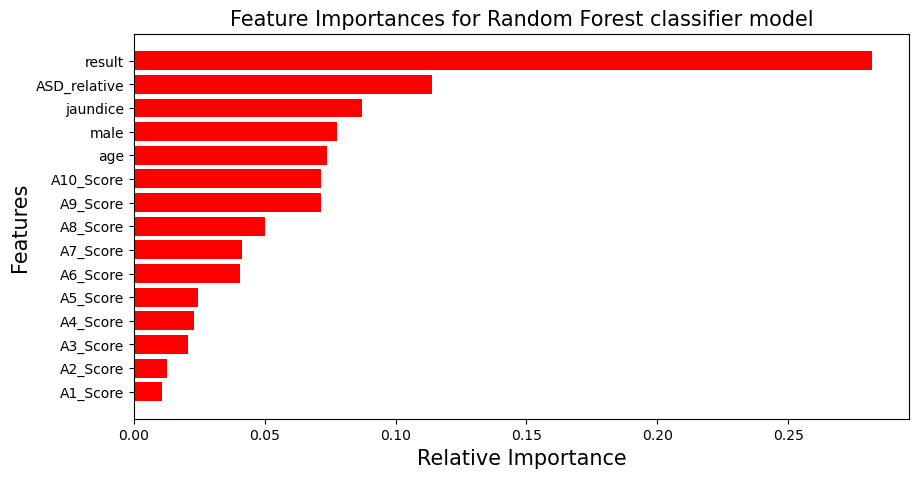

In [39]:
features = X
importances = list(rf.feature_importances_)
imp=np.sort(importances)
tab=pd.DataFrame(list(zip(X,imp)),columns =['Features', 'Importance scores']) 
print(tab)

#Visual comparison:
plt.figure(figsize=(10,5))
#indices = np.argsort(importances)
index = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
_ = plt.barh(index,imp, align='center',color='r')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, features)
plt.title('Feature Importances for Random Forest classifier model',fontsize=15)

In [40]:
from sklearn.metrics import auc, roc_curve, roc_auc_score
y_scores_rf = rf.predict_proba(X_test)
y_scores_rf = y_scores_rf[:,1]
auroc = roc_auc_score(y_test, y_scores_rf)
print("ROC-AUC Score:", auroc)

ROC-AUC Score: 0.8920826513911619


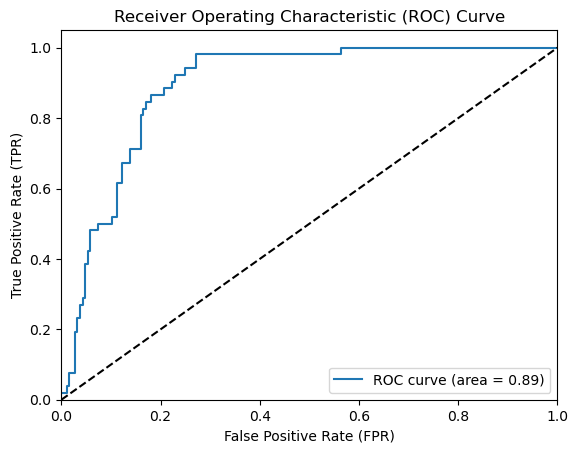

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores_rf)
auc_score = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## B. Gradient Boost

In [33]:
xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, n_estimators=100)
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8125

In [35]:
cv_scores_test= cross_val_score(xgb_classifier,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(xgb_classifier,X_train,y_train,cv=5,scoring='roc_auc')

print ('Mean cross validation test score: ' +str(cv_scores_test.mean()))
print ('Mean cross validation train score: ' +str(cv_scores_train.mean()))
print ('Standard deviation in cv test scores: ' +str(cv_scores_test.std()))

Mean cross validation test score: 0.8828255528255529
Mean cross validation train score: 0.8851094936809224
Standard deviation in cv test scores: 0.03584573645970753


## C. Support Vector Machine

In [18]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)


y_predict_svm=svm.predict(X_test)


cnf_matrix = confusion_matrix(y_test, y_predict_svm)
print(cnf_matrix)

accuracy_svm=svm.score(X_test,y_test)
print(accuracy_svm)

[[169  19]
 [ 25  27]]
0.8166666666666667


In [36]:
cv_scores_test= cross_val_score(svm,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(svm,X_train,y_train,cv=5,scoring='roc_auc')

print ('Mean cross validation test score: ' +str(cv_scores_test.mean()))
print ('Mean cross validation train score: ' +str(cv_scores_train.mean()))
print ('Standard deviation in cv test scores: ' +str(cv_scores_test.std()))

Mean cross validation test score: 0.8935988620199147
Mean cross validation train score: 0.9125014667871809
Standard deviation in cv test scores: 0.040549308737848566


## D. Logistic Regression

In [14]:
C_param_range = [0.001,0.01,0.1,1,10,100]

table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
table['C_parameter'] = C_param_range


j = 0
for i in C_param_range:
    
    Logreg = LogisticRegression(penalty = 'l2', C = i)
    Logreg.fit(X_train,y_train)
    
    y_pred_lr = Logreg.predict(X_test)
    
    table.iloc[j,1] = accuracy_score(y_test,y_pred_lr)
    j += 1
    
table  

,C_parameter,Accuracy
0,0.001,0.783333
1,0.010,0.783333
2,0.100,0.825
3,1.000,0.804167
4,10.000,0.804167
5,100.000,0.804167


In [15]:
confusion_matrix(y_pred_lr, y_test)

array([[167,  26],
       [ 21,  26]])

In [25]:
cv_scores_test= cross_val_score(Logreg,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(Logreg,X_train,y_train,cv=5,scoring='roc_auc')

print ('Mean cross validation test score: ' +str(cv_scores_test.mean()))
print ('Mean cross validation train score: ' +str(cv_scores_train.mean()))
print ('Standard deviation in cv test scores: ' +str(cv_scores_test.std()))

Mean cross validation test score: 0.8906181300918143
Mean cross validation train score: 0.9134324405752977
Standard deviation in cv test scores: 0.04197211379921044


## E. K Nearest Neighbors

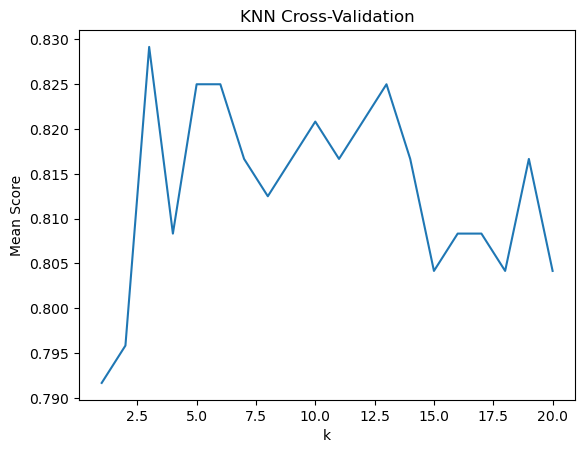

In [29]:

k_values = range(1, 21)

scores = []

for k in k_values:

    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    
    knn_classifier.fit(X_train, y_train)
    
    y_pred = knn_classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    scores.append(accuracy)

plt.plot(k_values, scores)
plt.xlabel('k')
plt.ylabel('Mean Score')
plt.title('KNN Cross-Validation')
plt.show()



In [30]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)
    
knn_classifier.fit(X_train, y_train)
    
y_pred = knn_classifier.predict(X_test)
    
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8291666666666667

## Compare the Models

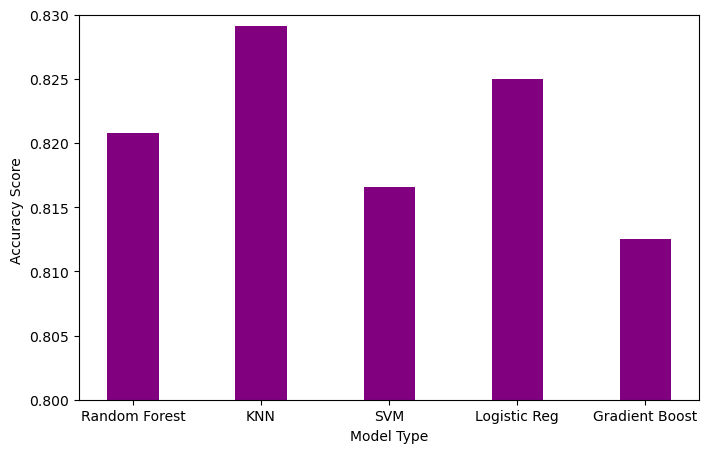

In [17]:
names = ['Random Forest', 'KNN', 'SVM', 'Logistic Reg', 'Gradient Boost']
acc_scores = [0.8208, 0.8291, 0.8166, 0.825, 0.8125]

scores = pd.DataFrame({'Model': names, 'Accuracy Score': acc_scores})
scores.head()

plt.figure(figsize=(8,5))
_ = plt.bar('Model', 'Accuracy Score', data=scores, color='purple', width=0.4)
plt.xlabel('Model Type')
plt.ylabel('Accuracy Score ')
plt.ylim(0.80, 0.83)
plt.show()